### Segmenting and Clustering Neighborhoods in Toronto-(Bourough:Scarborough)

### Project Overview:

In this project segmentation and clustering of neighborhoods in the city of Toronto in the province of Ontario, Canada, is presented. Data for this project is outsourced from a geolocation dataset from "List of postal codes of Canada: M" in Wikipedia and a cvs-file of Toronto city Geospatial data. The Foursquare API will be used to find the venues on each postal code zone using a radius based on the area cover by each postcode without overlapping between them and a maximum number of venues per postal code of 100. Unsupervised Machine Learning (K-Means clustering algorithm) is used to group the postal codes based on the venues density (venues/area), and the Folium library is used to visualize the results, neighborhoods and their emerging clusters on a map of Toronto.

### PART 1

#### Pre-processing:

Before we get the data and start exploring it, let's import all modules, libraries and dependencies that we will need.

In [5]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Extract the raw table from the wikipaedia page.

Scrape the Wikipedia page, wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format. The BeautifulSoup library is used to scrape the Wikipedia's article that contains the Toronto neighborhood data. The neighborhood data presented in a Table n the article is parsed and stored in a list that contains each row of the table, that is the Postcode, Borough and Neighborhood name.

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

#### Transform the data into a pandas dataframe.

The neighborhood_info list is passed to a pandas module to format and create a DataFrame consistING of three columns: PostalCode, Borough, and Neighborhood

In [7]:
#create a Neighborhoods dataframe
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


#### Explore and clean neighborhood dataset

The data returned has missing info like "Not assigned" boroughs and neighborhoods. Ignore cells with a borough that is tagged "Not assigned" and only process cells that have an assigned borough. For cells that has a borough but a "Not assigned" Neighborhood, the neighborhood will be the same as the borough. More than one neighborhood can exist in one postal code area.

In [8]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (289, 3) 

There are:
  180 Postal codes
  11 Boroughs
  209 Neighborhoods
  77 rows with Not assigned Borough
  78 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



#### Eliminate The rows with "Not assigned" Boroughs

In [9]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


#### Replace the "Not assigned" values in the Neighborhood column with the Borough name in that cell.

In [10]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


#### Examine the neighborhood dataframe and dimensions

In [11]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (212, 3) 

There are:
  103 Postal codes
  11 Boroughs
  210 Neighborhoods


The dataframe has the following dimensions: 103 Postal codes but it has 212 rows, and this is because a unique Postal code can present more than one neighborhood (210 in total). Grouping the dataframe by "Postal code" makes it possible to mimic the data format in the Toronto Geospatial dataset.

In [12]:
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [13]:
# make the column name the same
grouped_df.rename(columns={'Postcode':'PostalCode'}, inplace = True)
grouped_df.head(15)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [14]:
print('The dataframe has {} Boroughs and {} Neighborhoods.'.format(
        len(grouped_df['Borough'].unique()),
      grouped_df.shape[0]
    )
)

The dataframe has 11 Boroughs and 103 Neighborhoods.


In [15]:
grouped_df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [16]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (103, 3)


### PART 2

To utilize the Foursquare API and geo-location data, we first need to get the latitude and the longitude coordinates of each neighborhood.
In the second part of this project i extract the geographical coordinates of the neighborhoods in the Toronto and format it tnto a Dataframe for furher exploratory analysis, with the Geocoder package and/or the Toronto Geospatial data file.


#### Read the Toronto Geospatial data file by the URL and assign it to a Dataframe variable "coordinates_df"

In [17]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data 
print('Data downloaded!')

Data downloaded!


In [18]:
coordinates_df = pd.read_csv('Geospatial_Coordinates.csv') # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge the two Dataframes by column "Postcode", their unique primary key.

In [19]:
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='PostalCode')

postcodes_with_coordinates_df.head(16)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [20]:
print('The dataframe has {} Boroughs and {} Neighborhoods.'.format(
        len(postcodes_with_coordinates_df['Borough'].unique()),
        postcodes_with_coordinates_df.shape[0]
    )
)

The dataframe has 11 Boroughs and 103 Neighborhoods.


### PART 3

In the final part of this project,i analyze, explore and cluster the neighborhoods in the city of Toronto, Canada. I use the Foursquare API to explore and analyze neighborhoods in Toronto City by Venue densities, and convert venue addresses into their equivalent latitude and longitude values. I used the explore function to get the most common venue categories for a single neighborhood in the city of Toronto, Scarborough, and then used this feature to group the neighborhoods in Scarborough into clusters by way of the k-means clustering algorithm. The Folium library is also to visualize the neighborhoods and their emerging clusters.

#### import all modules, libraries and dependencies

In [23]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Toronto

In [24]:
from geopy.geocoders import Nominatim
address = 'Toronto, CA'

#geolocator = Nominatim()
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
latitude=43.653963
longitude=-79.387207
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### With the coordinates of each postal code formatted in a Datatframe, a map of Toronto with markers indicating the Postcode position is generated.

In [21]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'],
                                           postcodes_with_coordinates_df['Borough'], postcodes_with_coordinates_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Toronto)  
    
map_Toronto

The map shows that the Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

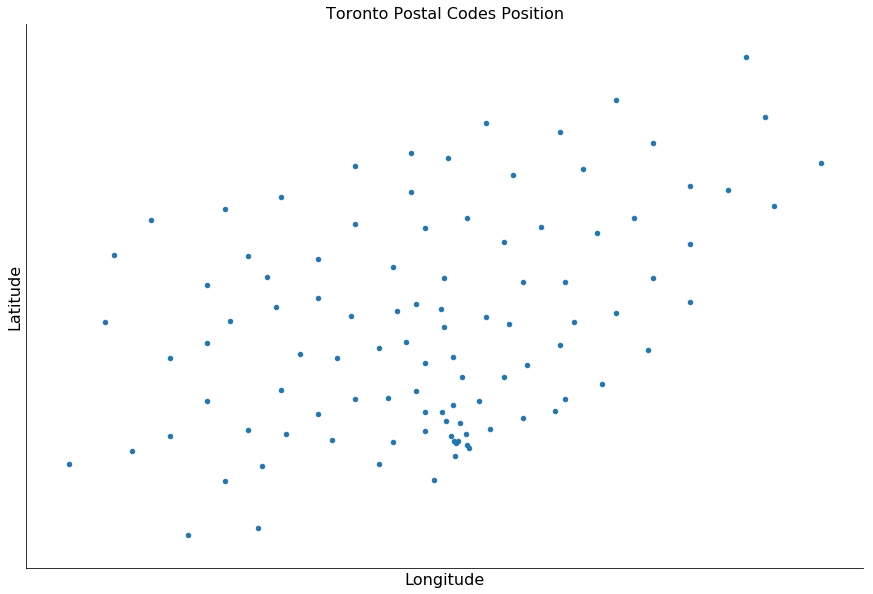

In [25]:
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

#### To define the radius use with foursquare it's necessary to find the closest points for each postcode.

In [26]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

#### To be able to explore the distance function, the closest postcode to the first example in the dataframe is found

In [27]:
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


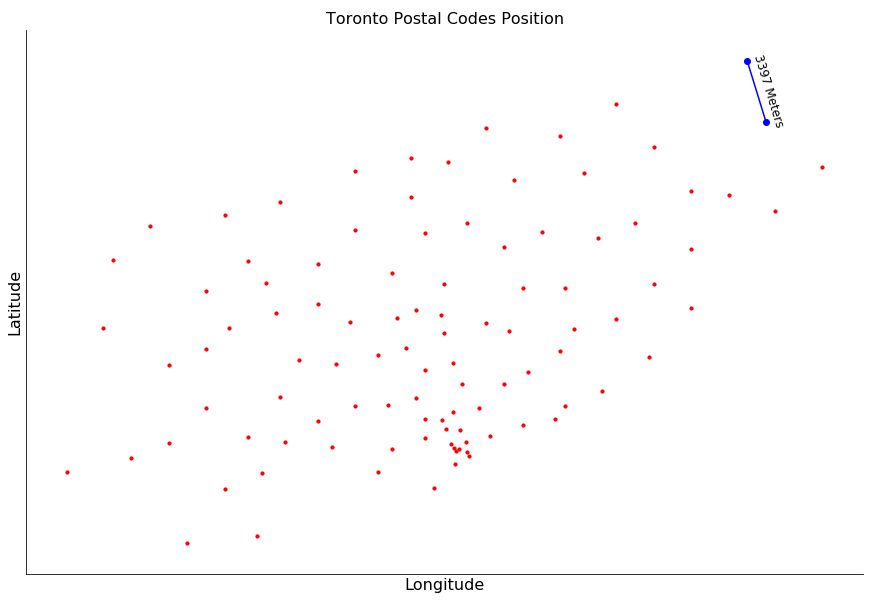

In [28]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

#### A "Distance" column is added to the DataFrame and is used as the radius cover for each postcode

In [30]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


#### A new map for the city of Toronto is plotted using different radius for each postal code.
#### In this new map we avoide the overlapping issue as more area of the city is covered. Consequently, more venues will be retrieved

In [31]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

#### Exploration and Cluster analysis for this project will be based on one neighborhood or postal code for simplicity of illustration.
The neighborhood of Scarborough segmented and explored to get venues using the Foursquare API.


#### Slice the original dataframe and create a new dataframe of the Scarborough data.

In [32]:
Scarborough_data = postcodes_with_coordinates_df[postcodes_with_coordinates_df['Borough'] == 'Scarborough'].reset_index(drop=True)
Scarborough_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


#### Get the geographical coordinates of Scarborough

In [33]:
address = 'Scarborough, CA'

#geolocator = Nominatim()
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
latitude = 43.773077
longitude = -79.257774
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough are 43.773077, -79.257774.


#### Visualize the map of Scarborough with the neighborhoods superimposed on to it

In [34]:
# create map of Scarborough using latitude and longitude values
map_Scarborough = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Scarborough_data['Latitude'], Scarborough_data['Longitude'], Scarborough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Scarborough)  
    
map_Scarborough

#### Get Venues
To get venues using the Foursquare API, Foursquare developer credentials must be declared.

Foursquare Credentials and Version

In [36]:
CLIENT_ID = 'ZDJMU5JIZC5FCHUCYLERI3DMGMAFXF04AQG2GGDOBVV0NMKF' # your Foursquare ID
CLIENT_SECRET = 'ORFEGXHRTNKRITZGL5GJAQVDXWJFK2L00KI3BJVWF2HD4RKK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZDJMU5JIZC5FCHUCYLERI3DMGMAFXF04AQG2GGDOBVV0NMKF
CLIENT_SECRET:ORFEGXHRTNKRITZGL5GJAQVDXWJFK2L00KI3BJVWF2HD4RKK


#### Let's explore the first Scarborough neighborhood in our dataframe

In [37]:
Scarborough_data.loc[0, 'Neighborhood']

'Rouge, Malvern'

In [38]:
Scarborough_data.shape

(17, 6)

In [39]:
neighborhood_latitude = Scarborough_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Scarborough_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Scarborough_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


#### Get the top 100 venues that are in Malvern within a radius of 500 meters.
Trace the url link to fetch the data from foursquare

In [40]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ZDJMU5JIZC5FCHUCYLERI3DMGMAFXF04AQG2GGDOBVV0NMKF&client_secret=ORFEGXHRTNKRITZGL5GJAQVDXWJFK2L00KI3BJVWF2HD4RKK&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

#### Get the json from the url

In [41]:
s = requests.get(url)
results = s.json()

In [42]:
results

{'meta': {'code': 200, 'requestId': '5c4474af6a6071298d84fe5c'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': "Wendy's",
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

#### All the information is in the items key.
Lets create a get_category_type function to get the category's type.

In [43]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Check how many venues from the url_json

In [44]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


In [45]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


#### Create a function to find nearby venues

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
Scarborough_venues = getNearbyVenues(names=Scarborough_data['Neighborhood'],
                                   latitudes=Scarborough_data['Latitude'],
                                   longitudes=Scarborough_data['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge


In [48]:
Scarborough_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop


In [49]:
Scarborough_data.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,1480.0
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1144.0
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,1480.0
15,M1W,Scarborough,"L'Amoreaux West, Steeles West",43.799525,-79.318389,1144.0
16,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,1698.0


#### Since we can't find venues in "Upper Rouge", we remove the row from Scarborough_datA

In [50]:
Scarborough_data.drop(index=16,axis=0,inplace=True)
Scarborough_data.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
11,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,993.0
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,1480.0
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,1144.0
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,1480.0
15,M1W,Scarborough,"L'Amoreaux West, Steeles West",43.799525,-79.318389,1144.0


In [51]:
print(Scarborough_venues.shape)
Scarborough_venues.head()

(87, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [52]:
Scarborough_venues.groupby('Neighborhood').head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop
10,Woburn,43.770992,-79.216917,Tim Hortons,43.770827,-79.223078,Coffee Shop


#### Check how many venues were returned for each neighborhood

In [53]:
Scarborough_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Birch Cliff, Cliffside West",4,4,4,4,4,4
Cedarbrae,8,8,8,8,8,8
"Clairlea, Golden Mile, Oakridge",10,10,10,10,10,10
"Clarks Corners, Sullivan, Tam O'Shanter",9,9,9,9,9,9
"Cliffcrest, Cliffside, Scarborough Village West",3,3,3,3,3,3
"Dorset Park, Scarborough Town Centre, Wexford Heights",7,7,7,7,7,7
"East Birchmount Park, Ionview, Kennedy Park",6,6,6,6,6,6


#### It is necessary to extract the Category (shortName) of the JSON data to find the number of unique categories can be curated from all the returned venues.

In [54]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))

There are 53 uniques categories.


#### Analyze Scaborough Venues

In [55]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]

Scarborough_onehot.head()

,Neighborhood,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping,Cosmetics Shop,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,General Entertainment,Grocery Store,Hakka Restaurant,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Motel,Moving Target,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Thrift / Vintage Store,Train Station,Vietnamese Restaurant
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
Scarborough_onehot.shape

(87, 54)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [57]:
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_grouped

,Neighborhood,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping,Cosmetics Shop,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,General Entertainment,Grocery Store,Hakka Restaurant,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Motel,Moving Target,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Thrift / Vintage Store,Train Station,Vietnamese Restaurant
0,Agincourt,0.000000,0.000,0.000000,0.000000,0.000,0.0,0.250000,0.0,0.0,0.00,0.000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.250,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.25,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.5,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,"Birch Cliff, Cliffside West",0.000000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.25,0.000,0.000000,0.000000,0.25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Cedarbrae,0.000000,0.125,0.000000,0.125000,0.125,0.0,0.000000,0.0,0.0,0.00,0.125,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.125,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.125000,0.000000,0.000000,0.000000
4,"Clairlea, Golden Mile, Oakridge",0.000000,0.000,0.000000,0.200000,0.000,0.0,0.000000,0.2,0.1,0.00,0.000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.100000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.1,0.000000,0.000000,0.0,0.000000,0.1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.1,0.000000,0.000000,0.000000,0.000000
5,"Clarks Corners, Sullivan, Tam O'Shanter",0.000000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.00,0.000,0.111111,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.111111,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.111111,0.0,0.000000,0.111111,0.222222,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.111111,0.000000,0.000000,0.000000
6,"Cliffcrest, Cliffside, Scarborough Village West",0.333333,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.333333,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,"Dorset Park, Scarborough Town Centre, Wexford ...",0.000000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.00,0.000,0.142857,0.000000,0.00,0.0,0.000000,0.000000,

In [58]:
Scarborough_grouped.shape

(16, 54)

#### Lets review the top5 most venues for each neighborhood

In [59]:
num_top_venues = 5

for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                 venue  freq
0               Lounge  0.25
1       Breakfast Spot  0.25
2         Skating Rink  0.25
3       Sandwich Place  0.25
4  American Restaurant  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                 venue  freq
0           Playground   0.5
1                 Park   0.5
2  American Restaurant   0.0
3            Pet Store   0.0
4    Korean Restaurant   0.0


----Birch Cliff, Cliffside West----
                   venue  freq
0  General Entertainment  0.25
1           Skating Rink  0.25
2                   Café  0.25
3        College Stadium  0.25
4    American Restaurant  0.00


----Cedarbrae----
                venue  freq
0              Lounge  0.12
1              Bakery  0.12
2                Bank  0.12
3  Athletics & Sports  0.12
4     Thai Restaurant  0.12


----Clairlea, Golden Mile, Oakridge----
           venue  freq
0         Bakery   0.2
1       Bus Line   0.2
2   Intersection   0.1
3  Metro Station   0.

#### Create a function to sort the most common venues by Descending order

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Let's create the new dataframe and display the top 10 venues for each neighborhood

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Sandwich Place,Breakfast Spot,Lounge,Vietnamese Restaurant,College Stadium,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Vietnamese Restaurant,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store,Department Store
2,"Birch Cliff, Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Vietnamese Restaurant,Grocery Store,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
3,Cedarbrae,Athletics & Sports,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Cosmetics Shop
4,"Clairlea, Golden Mile, Oakridge",Bus Line,Bakery,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Park,Soccer Field,Bar,Cosmetics Shop
5,"Clarks Corners, Sullivan, Tam O'Shanter",Pizza Place,Chinese Restaurant,Noodle House,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Fast Food Restaurant,Pharmacy,College Stadium,Construction & Landscaping
6,"Cliffcrest, Cliffside, Scarborough Village West",Intersection,Motel,American Restaurant,Thai Restaurant,Coffee Shop,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
7,"Dorset Park, Scarborough Town Centre, Wexford ...",Indian Restaurant,Chinese Restaurant,Furniture / Home Store,Latin American Restaurant,Pet Store,Vietnamese Restaurant,Bar,Breakfast Spot,Grocery Store,General Entertainment
8,"East Birchmount Park, Ionview, Kennedy Park",Discount Store,Coffee Shop,Chinese Restaurant,Department Store,Train Station,Bank,Bar,Hakka Restaurant,Grocery Store,General Entertainment
9,"Guildwood, Morningside, West Hill",Electronics Store,Breakfast Spot,Rental Car Location,Medical Center,Pizza Place,Mexican Restaurant,Vietnamese Restaurant,College Stadium,Furniture / Home Store,Fried Chicken Joint


#### Analyze Venues data
In order to get a better sense of the best way of clustering the Scarborough neighborhood, it's necessary to analyze the venues data returned by Foursquare

In [62]:
Scarborough_venues_density = Scarborough_venues.groupby('Neighborhood').count()
Scarborough_venues_density = pd.DataFrame(list(zip(Scarborough_venues_density.index, Scarborough_venues_density['Venue'])), 
                                  columns=['Neighborhood', '# of Venues'])

In [63]:
Scarborough_venues_density

,Neighborhood,# of Venues
0,Agincourt,4
1,"Agincourt North, L'Amoreaux East, Milliken, St...",2
2,"Birch Cliff, Cliffside West",4
3,Cedarbrae,8
4,"Clairlea, Golden Mile, Oakridge",10
5,"Clarks Corners, Sullivan, Tam O'Shanter",9
6,"Cliffcrest, Cliffside, Scarborough Village West",3
7,"Dorset Park, Scarborough Town Centre, Wexford ...",7
8,"East Birchmount Park, Ionview, Kennedy Park",6
9,"Guildwood, Morningside, West Hill",6


In [64]:
print('Total Scarborough Neighborhood:', Scarborough_venues_density['Neighborhood'].shape[0])
print('Total Scarborough Neighborhood Venues:', Scarborough_venues.shape[0])

Total Scarborough Neighborhood: 16
Total Scarborough Neighborhood Venues: 87


#### The Scarborough neighborhood is clustered based on venues density.
One important hyperparameter is the number of clusters. Here, we use elbow method to get a better sense of the optimal number.

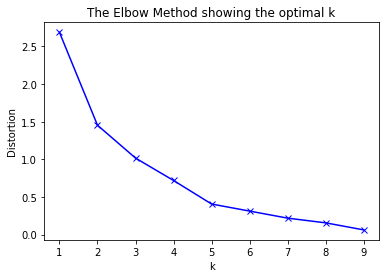

In [66]:
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(Scarborough_venues_density['# of Venues'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(Scarborough_venues_density['# of Venues'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / Scarborough_venues_density['# of Venues'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Cluster Scarborough Neighborhoods
Using the elbow method, the optimal value of the number of cluster was defined as 5 Run k-means to cluster the neighborhood into 5 clusters.

In [67]:
# set number of clusters
kclusters = 5

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Let's create a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood.

In [68]:
Scarborough_merged = Scarborough_data

# add clustering labels
Scarborough_merged['Cluster Labels'] = kmeans.labels_

In [69]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0,0,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Grocery Store,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Electronics Store,Discount Store,Department Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0,2,Bar,Moving Target,Vietnamese Restaurant,College Stadium,Grocery Store,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0,0,Electronics Store,Breakfast Spot,Rental Car Location,Medical Center,Pizza Place,Mexican Restaurant,Vietnamese Restaurant,College Stadium,Furniture / Home Store,Fried Chicken Joint
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0,0,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0,0,Athletics & Sports,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Cosmetics Shop


#### Let's visualize the resulting clusters

In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Scarborough_merged['Latitude'], Scarborough_merged['Longitude'], Scarborough_merged['Neighborhood'], Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters
We examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [71]:
Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0, Scarborough_merged.columns[[1] + list(range(5, Scarborough_merged.shape[1]))]]

,Borough,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1698.0,0,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Grocery Store,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Electronics Store,Discount Store,Department Store
2,Scarborough,1205.0,0,Electronics Store,Breakfast Spot,Rental Car Location,Medical Center,Pizza Place,Mexican Restaurant,Vietnamese Restaurant,College Stadium,Furniture / Home Store,Fried Chicken Joint
3,Scarborough,913.0,0,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
4,Scarborough,913.0,0,Athletics & Sports,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Vietnamese Restaurant,Cosmetics Shop
5,Scarborough,1302.0,0,Playground,Construction & Landscaping,Vietnamese Restaurant,Coffee Shop,Grocery Store,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
6,Scarborough,1113.0,0,Discount Store,Coffee Shop,Chinese Restaurant,Department Store,Train Station,Bank,Bar,Hakka Restaurant,Grocery Store,General Entertainment
7,Scarborough,1052.0,0,Bus Line,Bakery,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Park,Soccer Field,Bar,Cosmetics Shop
8,Scarborough,1113.0,0,Intersection,Motel,American Restaurant,Thai Restaurant,Coffee Shop,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
9,Scarborough,1297.0,0,College Stadium,General Entertainment,Skating Rink,Café,Vietnamese Restaurant,Grocery Store,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
11,Scarborough,993.0,0,Sandwich Place,Auto Garage,Bakery,Smoke Shop,Shopping Mall,Breakfast Spot,Fast Food Restaurant,Cosmetics Shop,Department Store,Discount Store


In [72]:
Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1, Scarborough_merged.columns[[1] + list(range(5, Scarborough_merged.shape[1]))]]

,Borough,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Scarborough,1144.0,1,Pizza Place,Chinese Restaurant,Noodle House,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Fast Food Restaurant,Pharmacy,College Stadium,Construction & Landscaping


In [73]:
Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2, Scarborough_merged.columns[[1] + list(range(5, Scarborough_merged.shape[1]))]]

,Borough,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1625.0,2,Bar,Moving Target,Vietnamese Restaurant,College Stadium,Grocery Store,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
14,Scarborough,1480.0,2,Park,Playground,Vietnamese Restaurant,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store,Department Store


In [74]:
Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 3, Scarborough_merged.columns[[1] + list(range(5, Scarborough_merged.shape[1]))]]

,Borough,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Scarborough,993.0,3,Indian Restaurant,Chinese Restaurant,Furniture / Home Store,Latin American Restaurant,Pet Store,Vietnamese Restaurant,Bar,Breakfast Spot,Grocery Store,General Entertainment


In [75]:
Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 4, Scarborough_merged.columns[[1] + list(range(5, Scarborough_merged.shape[1]))]]

,Borough,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Scarborough,1144.0,4,Chinese Restaurant,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Cosmetics Shop,Grocery Store,Pharmacy,Pizza Place,Coffee Shop,Japanese Restaurant


#### This is the end of this project.


In this project work is done on how to cluster data, a form of unsupervised machine learning, using the k-means clustering algorithm.
I explored neighborhoods in the city of Toronto, Canada, segmented and grouped them into clusters to find similarities in these neighborhoods.


#### Applications

The work herein concluded has the potential to harness meaningful insight and contextualization, in sync with social data, mobile data, user data, sensor data. “Location Intelligence (LI) is defined as the capacity to organize and understand complex data through the use of geographic relationships. LI organizes business and geographically referenced data to reveal the relationship of location to people, events, transactions, facilities, and assets.
Business use cases include supply chain model for product delivery,  personalized branch marketing strategies, etc.


# Thank You!